<a href="https://colab.research.google.com/github/willytsinda/Prostate-Cancer-Detection/blob/main/Prosate_Cancer_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROSTATEx-2 Analysis: Cancer Detection & Grading
**Notebook Structure**:
1. Setup & Data Loading
2. Attention U-Net for Cancer Detection
3. Ensemble Model (RF + SVM) for GGG Prediction
4. Combined Inference

**1. Setup & Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dependencies


In [ ]:
!pip install pydicom tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.3 MB/s eta 0:00:00


In [ ]:

"""import os
import numpy as np
import pandas as pd
import pydicom
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Multiply, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt"""

In [ ]:
import os
import numpy as np
import pandas as pd
import pydicom
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.utils import plot_model

**Copy all T2 weighted dcm files in one folder**

In [ ]:

# Iterate through all patient directories in the base_dir
for patient_dir in os.listdir(base_dir):
    patient_path = os.path.join(base_dir, patient_dir)

    # Ensure it's a directory (skip files)
    if not os.path.isdir(patient_path):
        continue

    # Iterate through all study directories in the patient directory
    for study_dir in os.listdir(patient_path):
        study_path = os.path.join(patient_path, study_dir)

        # Ensure it's a directory (skip files)
        if not os.path.isdir(study_path):
            continue

        # Iterate through all series directories in the study directory
        for series_dir in os.listdir(study_path):
            series_path = os.path.join(study_path, series_dir)

            # Ensure it's a directory (skip files)
            if not os.path.isdir(series_path):
                continue

            # Check if the series is a T2-weighted series
            series_description = series_dir.split('-')[-2]  # Extract series description from directory name
            if any(t2_desc.lower() in series_description.lower() for t2_desc in ['t2', 't2w', 't2-weighted']):
                # Copy all DICOM files in the series directory
                for dicom_file in os.listdir(series_path):
                    if dicom_file.endswith('.dcm'):
                        src = os.path.join(series_path, dicom_file)
                        dst = os.path.join(images_dir, f"{patient_dir}_{series_dir}_{dicom_file}")

                        # Check if the file already exists in the destination folder
                        if not os.path.exists(dst):
                            shutil.copy(src, dst)
                            print(f"Copied: {src} -> {dst}")
                        else:
                            print(f"Skipped (already exists): {dst}")

print("T2-weighted DICOM files organized.")

Streaming output truncated to the last 5000 lines.
Skipped (already exists): /content/drive/MyDrive/Prostate Cancer/dcmimages/ProstateX-0176_4.000000-t2tsetra-97964_1-21.dcm
Skipped (already exists): /content/drive/MyDrive/Prostate Cancer/dcmimages/ProstateX-0176_6.000000-t2tsecor-14993_1-01.dcm
Skipped (already exists): /content/drive/MyDrive/Prostate Cancer/dcmimages/ProstateX-0176_6.000000-t2tsecor-14993_1-02.dcm
Skipped (already exists): /content/drive/MyDrive/Prostate Cancer/dcmimages/ProstateX-0176_6.000000-t2tsecor-14993_1-04.dcm
Skipped (already exists): /content/drive/MyDrive/Prostate Cancer/dcmimages/ProstateX-0176_6.000000-t2tsecor-14993_1-03.dcm
Skipped (already exists): /content/drive/MyDrive/Prostate Cancer/dcmimages/ProstateX-0176_6.000000-t2tsecor-14993_1-05.dcm
Skipped (already exists): /content/drive/MyDrive/Prostate Cancer/dcmimages/ProstateX-0176_6.000000-t2tsecor-14993_1-08.dcm
Skipped (already exists): /content/drive/MyDrive/Prostate Cancer/dcmimages/ProstateX-017

**Exploratory Data Analysis**

In [ ]:
prostatex2_findings_train_metadata = pd.read_csv('/content/drive/MyDrive/Prostate Cancer/DataInfo-Train/ProstateX-2-Findings-Train.csv')
prostatex2_images_train_metadata = pd.read_csv('/content/drive/MyDrive/Prostate Cancer/DataInfo-Train/ProstateX-2-Images-Train.csv')
prostatex2_images_test_metadata = pd.read_csv('/content/drive/MyDrive/Prostate Cancer/DataInfo-Test/ProstateX-2-Images-Test.csv')
prostatex2_findings_test_metadata = pd.read_csv('/content/drive/MyDrive/Prostate Cancer/DataInfo-Test/ProstateX-2-Findings-Test.csv')

In [ ]:
print(prostatex2_findings_train_metadata.columns)

print(prostatex2_images_train_metadata.columns)

print(prostatex2_images_test_metadata.columns)

print(prostatex2_findings_test_metadata.columns)


Index(['ProxID', 'fid', 'pos', 'zone', 'ggg'], dtype='object')
Index(['ProxID', 'Name', 'studydate', 'fid', 'pos', 'WorldMatrix', 'ijk',
       'SpacingBetweenSlices', 'VoxelSpacing', 'Dim', 'DCMSerDescr',
       'DCMSerNum', 'DCMSerUID'],
      dtype='object')
Index(['ProxID', 'Name', 'studydate', 'fid', 'pos', 'WorldMatrix', 'ijk',
       'SpacingBetweenSlices', 'VoxelSpacing', 'Dim', 'DCMSerDescr',
       'DCMSerNum', 'DCMSerUID'],
      dtype='object')
Index(['ProxID', 'fid', 'pos', 'zone'], dtype='object')


In [ ]:
prostatex2_findings_train_metadata.describe()


,fid,ggg
count,112.000000,112.000000
mean,1.267857,2.187500
std,0.670916,1.151038
min,0.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,2.000000
75%,1.000000,3.000000
max,4.000000,5.000000


In [ ]:
prostatex2_findings_train_metadata_null = prostatex2_findings_train_metadata.isnull().sum()
n = [i for i in prostatex2_findings_train_metadata_null if i>0]

print("columns with missing values:%d"%len(n))

columns with missing values:0


In [ ]:
prostatex2_images_train_metadata.describe()


,studydate,fid,SpacingBetweenSlices,DCMSerNum
count,4.480000e+02,448.000000,448.000000,448.000000
mean,2.012069e+07,1.267857,3.199554,7.122768
std,3.109169e+02,0.668661,0.331426,7.089118
min,2.012010e+07,0.000000,3.000000,2.000000
25%,2.012043e+07,1.000000,3.000000,4.000000
50%,2.012071e+07,1.000000,3.000000,7.000000
75%,2.012092e+07,1.000000,3.600000,8.000000
max,2.012121e+07,4.000000,4.500000,60.000000


In [ ]:
prostatex2_images_train_metadata_null = prostatex2_images_train_metadata.isnull().sum()
n = [i for i in prostatex2_images_train_metadata_null if i>0]

print("columns with missing values:%d"%len(n))

columns with missing values:0


In [ ]:
prostatex2_images_test_metadata.describe()


,studydate,fid,SpacingBetweenSlices,DCMSerNum
count,2.800000e+02,280.000000,280.000000,280.000000
mean,2.012067e+07,1.214286,3.140357,6.785714
std,3.817848e+02,0.504968,0.285328,6.240446
min,2.012010e+07,1.000000,3.000000,3.000000
25%,2.012032e+07,1.000000,3.000000,4.000000
50%,2.012053e+07,1.000000,3.000000,7.000000
75%,2.012111e+07,1.000000,3.000000,8.000000
max,2.012123e+07,3.000000,4.000000,56.000000


In [ ]:
prostatex2_images_test_metadata_null = prostatex2_images_test_metadata.isnull().sum()
n = [i for i in prostatex2_images_test_metadata_null if i>0]

print("columns with missing values:%d"%len(n))

columns with missing values:0


In [ ]:
prostatex2_findings_test_metadata.describe()


,fid
count,70.000000
mean,1.214286
std,0.507705
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,3.000000


In [ ]:
prostatex2_findings_test_metadata_null = prostatex2_findings_test_metadata.isnull().sum()
n = [i for i in prostatex2_findings_test_metadata_null if i>0]

print("columns with missing values:%d"%len(n))

columns with missing values:0


In [ ]:
prostatex2_images_train_metadata['DCMSerDescr'].value_counts()


,count
DCMSerDescr,
t2_tse_sag,112
t2_tse_tra,111
ep2d_diff_tra_DYNDIST_ADC,81
ep2d_diff_tra_DYNDISTCALC_BVAL,81
ep2d_diff_tra_DYNDIST_MIXCALC_BVAL,23
ep2d_diff_tra_DYNDIST_MIX_ADC,23
diffusie-3Scan-4bval_fsCALC_BVAL,7
diffusie-3Scan-4bval_fs_ADC,7
ep2d_diff_tra2x2_Noise0_FS_DYNDISTCALC_BVAL,1


In [ ]:
prostatex2_images_test_metadata['DCMSerDescr'].value_counts()


,count
DCMSerDescr,
t2_tse_tra,70
t2_tse_sag,70
ep2d_diff_tra_DYNDISTCALC_BVAL,34
ep2d_diff_tra_DYNDIST_ADC,34
diff tra b 50 500 800 WIP511b alle spoelen_ADC,21
diff tra b 50 500 800 WIP511b alle spoelenCALC_BVAL,21
ep2d_diff_tra_DYNDIST_MIXCALC_BVAL,9
ep2d_diff_tra_DYNDIST_MIX_ADC,9
diffusie-3Scan-4bval_fsCALC_BVAL,6


<Axes: ylabel='DCMSerDescr'>

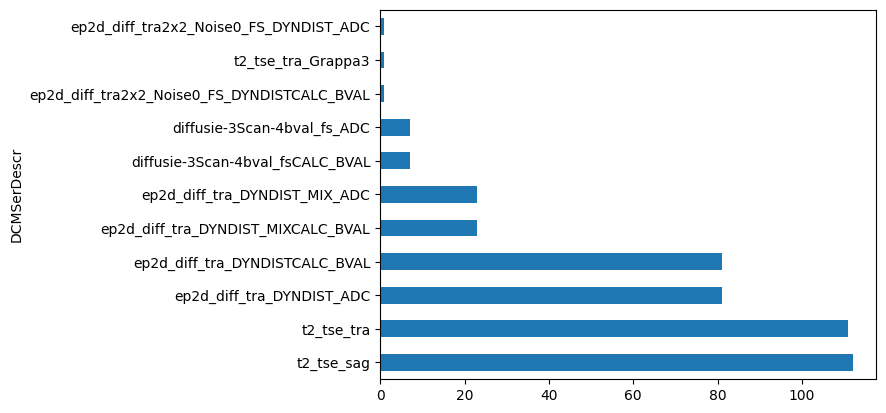

In [ ]:
prostatex2_images_train_metadata['DCMSerDescr'].value_counts().plot(kind='barh')


<Axes: ylabel='DCMSerDescr'>

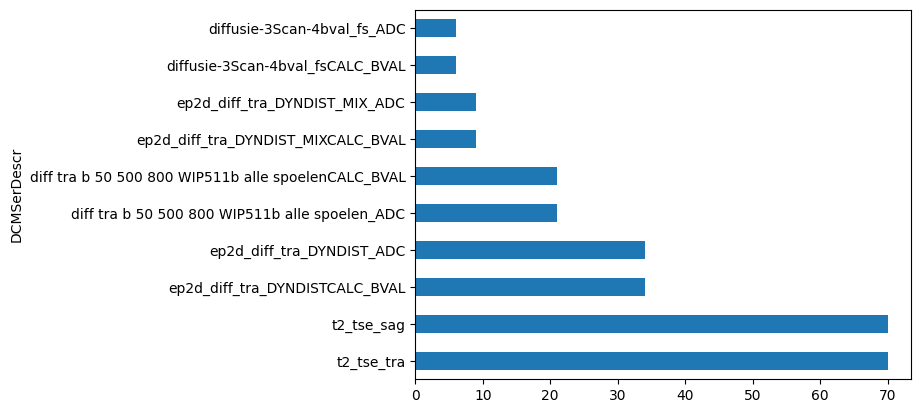

In [ ]:
prostatex2_images_test_metadata['DCMSerDescr'].value_counts().plot(kind='barh')


sample image exploration

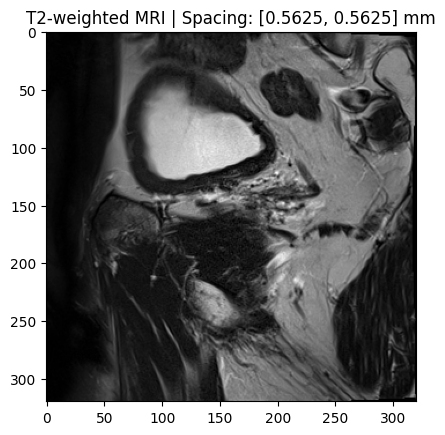

In [ ]:

# --- Step 1: Load DICOM ---
dcm_path = "/content/drive/MyDrive/Prostate Cancer/dcmimages/ProstateX-0000_3.000000-t2tsesag-87368_1-01.dcm"
dcm = pydicom.dcmread(dcm_path)

# --- Step 2: Extract Pixel Data & Metadata ---
pixel_array = dcm.pixel_array  # Shape: (H, W)
spacing = dcm.PixelSpacing  # [x, y] spacing in mm
position = dcm.ImagePositionPatient  # Scanner coordinates
series_desc = dcm.SeriesDescription  # e.g., 't2_tse_tra'

# --- Step 3: Preprocess ---
# Normalize to [0, 1]
normalized = (pixel_array - np.min(pixel_array)) / (np.max(pixel_array) - np.min(pixel_array))

# --- Step 4: Visualize ---
plt.imshow(normalized, cmap='gray')
plt.title(f"T2-weighted MRI | Spacing: {spacing} mm")
plt.show()

In [ ]:
# Paths definition
base_dir = '/content/drive/MyDrive/Prostate Cancer'
dcm_dir = os.path.join(base_dir, 'dcmimages')
train_meta_path = os.path.join(base_dir, 'DataInfo-Train/ProstateX-2-Images-Train.csv')
test_meta_path = os.path.join(base_dir, 'DataInfo-Test/ProstateX-2-Images-Test.csv')
train_findings_path = os.path.join(base_dir, 'DataInfo-Train/ProstateX-2-Findings-Train.csv')
test_findings_path = os.path.join(base_dir, 'DataInfo-Test/ProstateX-2-Findings-Test.csv')

In [ ]:
def get_t2_series(patient_id, data_type='Train'):
    """Get T2 series UID from metadata"""
    meta_path = train_meta_path if data_type == 'Train' else test_meta_path
    df = pd.read_csv(meta_path)

    # Filter for patient and T2 series
    patient_df = df[(df['ProxID'] == patient_id) &
                   (df['DCMSerDescr'].str.contains('t2', case=False))]

    if len(patient_df) == 0:
        raise ValueError(f"No T2 series found for {patient_id}")

    return patient_df['DCMSerUID'].iloc[0]  # Return SeriesInstanceUID


**One Patient**

In [ ]:
def load_single_patient(patient_id='ProstateX-0000'):
    """Load and validate patient DICOM data with automatic resizing

    Args:
        patient_id: Patient ID string (e.g., 'ProstateX-0000')

    Returns:
        Dictionary containing:
        - volume: 3D numpy array of standardized slices
        - spacing: [x,y,z] spacing in mm
        - annotations: DataFrame of clinical findings
        - metadata: Dictionary of DICOM headers
        - resized: Boolean indicating if resizing occurred
        - warnings: List of any non-critical issues
    """
    from skimage.transform import resize  # Import once at start

    try:
        # 1. Load metadata and validate
        meta_df = pd.read_csv(train_meta_path)
        patient_meta = meta_df[meta_df['ProxID'] == patient_id]

        if patient_meta.empty:
            raise ValueError(f"No metadata for {patient_id}")

        # 2. Find and validate DICOM files
        dcm_files = sorted(glob(os.path.join(dcm_dir, f'{patient_id}_*.dcm')))
        if not dcm_files:
            raise FileNotFoundError(f"No DICOMs matching {patient_id}_*.dcm")

        # 3. Process slices with comprehensive checks
        slices = []
        warnings = []
        ref_shape = None
        ref_spacing = None

        for f in dcm_files:
            try:
                dcm = pydicom.dcmread(f)
                if dcm.SeriesInstanceUID not in patient_meta['DCMSerUID'].values:
                    continue

                # Initialize reference dimensions from first valid slice
                if ref_shape is None:
                    ref_shape = (dcm.Rows, dcm.Columns)
                    ref_spacing = (float(dcm.PixelSpacing[0]),
                                 float(dcm.PixelSpacing[1]))

                # Validate spacing consistency
                current_spacing = (float(dcm.PixelSpacing[0]),
                                  float(dcm.PixelSpacing[1]))
                if current_spacing != ref_spacing:
                    warnings.append(f"Inconsistent spacing in {os.path.basename(f)}")

                # Standardize slice dimensions
                if (dcm.Rows, dcm.Columns) != ref_shape:
                    warnings.append(f"Resizing {os.path.basename(f)} from {(dcm.Rows, dcm.Columns)} to {ref_shape}")
                    pixels = resize(dcm.pixel_array, ref_shape,
                                   preserve_range=True).astype(dcm.pixel_array.dtype)
                else:
                    pixels = dcm.pixel_array

                slices.append({
                    'pixels': pixels,
                    'instance': int(dcm.InstanceNumber),
                    'original_shape': (dcm.Rows, dcm.Columns),
                    'spacing': current_spacing
                })

            except Exception as e:
                warnings.append(f"Error processing {os.path.basename(f)}: {str(e)}")
                continue

        if not slices:
            raise ValueError(f"No valid slices found for {patient_id}")

        # 4. Sort and stack slices
        slices.sort(key=lambda x: x['instance'])
        volume = np.stack([s['pixels'] for s in slices], axis=-1)

        # 5. Load annotations
        findings_df = pd.read_csv(train_findings_path)
        annotations = findings_df[findings_df['ProxID'] == patient_id]

        return {
            'volume': volume,
            'spacing': list(ref_spacing) + [float(slices[0]['spacing'][0])],  # Approximate z-spacing
            'annotations': annotations,
            'metadata': {
                'patient_id': patient_id,
                'num_slices': len(slices),
                'original_shapes': [s['original_shape'] for s in slices],
                'resized': any("Resizing" in w for w in warnings)
            },
            'warnings': warnings
        }

    except Exception as e:
        print(f"❌ Critical error loading {patient_id}: {e}")
        return None

**Test Loading**

Successfully loaded 38 slices
Volume shape: (320, 320, 38)
Spacing (mm): [0.5625, 0.5625, 0.5625]

Warnings encountered:
- Inconsistent spacing in ProstateX-0000_4.000000-t2tsetra-00702_1-01.dcm
- Resizing ProstateX-0000_4.000000-t2tsetra-00702_1-01.dcm from (384, 384) to (320, 320)
- Inconsistent spacing in ProstateX-0000_4.000000-t2tsetra-00702_1-02.dcm
- Resizing ProstateX-0000_4.000000-t2tsetra-00702_1-02.dcm from (384, 384) to (320, 320)
- Inconsistent spacing in ProstateX-0000_4.000000-t2tsetra-00702_1-03.dcm
- Resizing ProstateX-0000_4.000000-t2tsetra-00702_1-03.dcm from (384, 384) to (320, 320)
- Inconsistent spacing in ProstateX-0000_4.000000-t2tsetra-00702_1-04.dcm
- Resizing ProstateX-0000_4.000000-t2tsetra-00702_1-04.dcm from (384, 384) to (320, 320)
- Inconsistent spacing in ProstateX-0000_4.000000-t2tsetra-00702_1-05.dcm
- Resizing ProstateX-0000_4.000000-t2tsetra-00702_1-05.dcm from (384, 384) to (320, 320)
- Inconsistent spacing in ProstateX-0000_4.000000-t2tsetra-00702

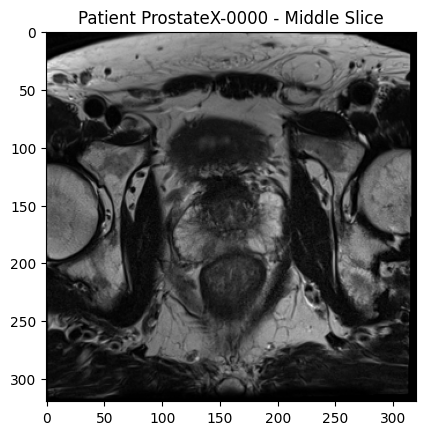

In [ ]:
# Test with visualization
patient_data = load_single_patient('ProstateX-0000')

if patient_data:
    print(f"Successfully loaded {patient_data['metadata']['num_slices']} slices")
    print(f"Volume shape: {patient_data['volume'].shape}")
    print(f"Spacing (mm): {patient_data['spacing']}")

    if patient_data['warnings']:
        print("\nWarnings encountered:")
        for w in patient_data['warnings'][:]:  # Show first 5 warnings
            print(f"- {w}")

    # Visualize middle slice
    plt.imshow(patient_data['volume'][..., patient_data['volume'].shape[2]//2],
               cmap='gray')
    plt.title(f"Patient {patient_data['metadata']['patient_id']} - Middle Slice")
    plt.show()

**Visualiziation with heatmap overlay**

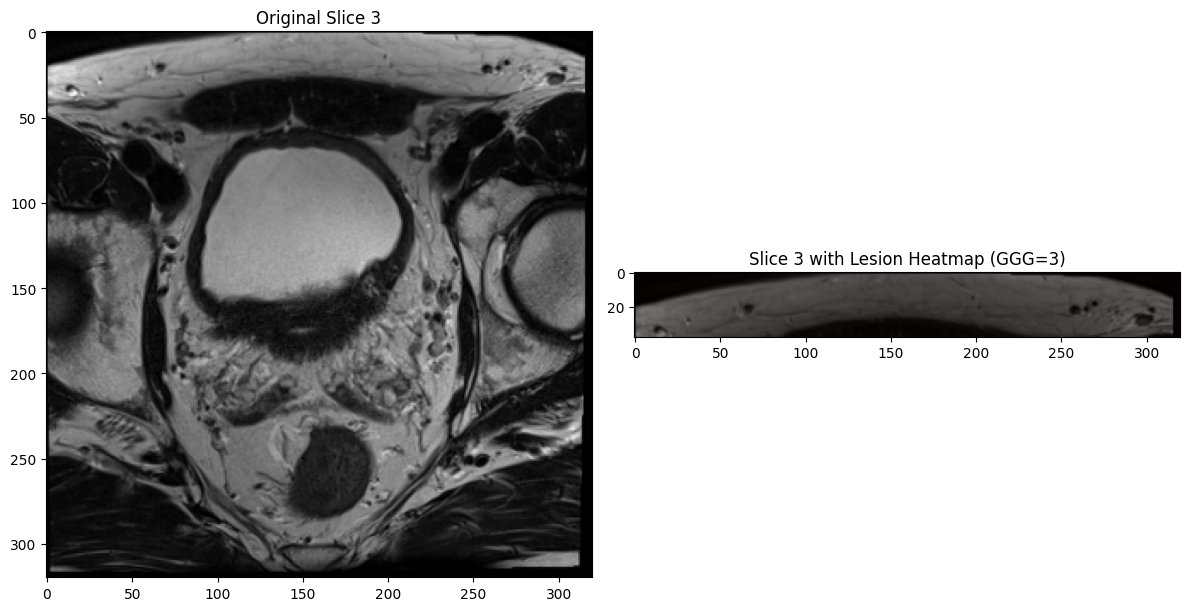

In [ ]:
def world_to_voxel(world_coords, world_matrix, spacing):
    """Convert world coordinates to voxel coordinates (ijk)"""
    # Extract the rotation and translation components from the world matrix
    # The world matrix is a 4x4 matrix in row-major order
    world_matrix = np.array(world_matrix).reshape(4,4)
    rotation = world_matrix[:3,:3]
    translation = world_matrix[:3,3]

    # Calculate the voxel coordinates
    voxel_coords = np.linalg.inv(rotation) @ (np.array(world_coords) - translation)
    voxel_coords = voxel_coords / np.array(spacing)
    return voxel_coords.astype(int)

def create_heatmap(volume_shape, center_ijk, sigma=5):
    """Create a 3D Gaussian heatmap centered at the lesion position"""
    # Create meshgrid
    zz, yy, xx = np.meshgrid(np.arange(volume_shape[2]),
                             np.arange(volume_shape[1]),
                             np.arange(volume_shape[0]), indexing='ij')

    # Calculate distances from center
    dist = ((xx - center_ijk[0])**2 +
            (yy - center_ijk[1])**2 +
            (zz - center_ijk[2])**2)

    # Create Gaussian heatmap
    heatmap = np.exp(-dist / (2 * sigma**2))
    return heatmap

def visualize_with_heatmap(patient_data, patient_meta, findings):
    """Visualize DICOM slice with heatmap overlay of lesion"""
    # Get the first finding for this patient
    finding = findings[findings['ProxID'] == patient_data['metadata']['patient_id']].iloc[0]

    # Get the corresponding metadata
    series_meta = patient_meta[patient_meta['fid'] == finding['fid']].iloc[0]

    # Convert world coordinates to voxel coordinates
    world_coords = list(map(float, finding['pos'].split()))
    world_matrix = list(map(float, series_meta['WorldMatrix'].split(',')))
    spacing = list(map(float, series_meta['VoxelSpacing'].split(',')))

    # Add slice spacing if needed (assuming 3D spacing)
    if len(spacing) == 2:
        spacing.append(series_meta['SpacingBetweenSlices'])

    ijk = world_to_voxel(world_coords, world_matrix, spacing)

    # Create heatmap
    heatmap = create_heatmap(patient_data['volume'].shape, ijk)

    # Select the slice closest to the lesion
    slice_idx = ijk[2]
    slice_idx = max(0, min(slice_idx, patient_data['volume'].shape[2]-1))

    # Create figure
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Show original slice
    ax[0].imshow(patient_data['volume'][..., slice_idx], cmap='gray')
    ax[0].set_title(f"Original Slice {slice_idx}")

    # Show slice with heatmap overlay
    ax[1].imshow(patient_data['volume'][..., slice_idx], cmap='gray')
    ax[1].imshow(heatmap[..., slice_idx], cmap='hot', alpha=0.5)
    ax[1].set_title(f"Slice {slice_idx} with Lesion Heatmap (GGG={finding['ggg']})")

    plt.tight_layout()
    plt.show()

# usage:
if patient_data:
    # Load metadata and findings
    meta_df = pd.read_csv(train_meta_path)
    findings_df = pd.read_csv(train_findings_path)

    # Get metadata for this patient
    patient_meta = meta_df[meta_df['ProxID'] == patient_data['metadata']['patient_id']]

    # Visualize
    visualize_with_heatmap(patient_data, patient_meta, findings_df)

**Segmentation Mask generation**

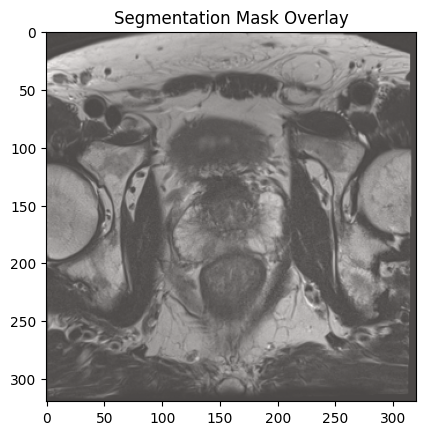

In [25]:
def generate_segmentation_mask(patient_data, patient_meta, findings_df):
    """Generate 3D binary mask from clinical findings."""
    volume_shape = patient_data['volume'].shape
    mask = np.zeros(volume_shape, dtype=np.float32)

    # Get all findings for this patient
    findings = findings_df[findings_df['ProxID'] == patient_data['metadata']['patient_id']]

    for _, lesion in findings.iterrows():
        # Get corresponding DICOM series metadata
        series_meta = patient_meta[patient_meta['fid'] == lesion['fid']].iloc[0]

        # Convert world coordinates to voxel coordinates
        world_coords = list(map(float, lesion['pos'].split()))
        world_matrix = list(map(float, series_meta['WorldMatrix'].split(',')))
        spacing = list(map(float, series_meta['VoxelSpacing'].split(',')))

        if len(spacing) == 2:
            spacing.append(float(series_meta['SpacingBetweenSlices']))

        ijk = world_to_voxel(world_coords, world_matrix, spacing)

        # Mark lesion area (5mm radius sphere)
        zz, yy, xx = np.ogrid[:volume_shape[0], :volume_shape[1], :volume_shape[2]]
        dist = ((xx - ijk[0])**2 + (yy - ijk[1])**2 + (zz - ijk[2])**2)
        mask[dist <= (5/np.min(spacing))**2] = 1  # 5mm radius

    return mask

# Generate mask for the patient
seg_mask = generate_segmentation_mask(patient_data, patient_meta, findings_df)

# Visualize
plt.imshow(patient_data['volume'][..., patient_data['volume'].shape[2]//2], cmap='gray')
plt.imshow(seg_mask[..., patient_data['volume'].shape[2]//2], alpha=0.3, cmap='Reds')
plt.title("Segmentation Mask Overlay")
plt.show()

**Attention U-net Implementation for single image**

In [23]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, multiply, Add, Activation
from tensorflow.keras.models import Model

def attention_gate(g, x, filters):
    """Attention gate for U-Net."""
    g_conv = Conv2D(filters, 1, padding='same')(g)
    x_conv = Conv2D(filters, 1, padding='same')(x)
    add = Add()([g_conv, x_conv])
    psi = Activation('relu')(add)
    psi = Conv2D(1, 1, padding='same', activation='sigmoid')(psi)
    return multiply([x, psi])

def attention_unet(input_shape=(320, 320, 1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)

    # Decoder with attention
    u1 = UpSampling2D((2, 2))(c3)
    a1 = attention_gate(c2, u1, 128)
    u1 = concatenate([u1, a1])
    c4 = Conv2D(128, 3, activation='relu', padding='same')(u1)

    u2 = UpSampling2D((2, 2))(c4)
    a2 = attention_gate(c1, u2, 64)
    u2 = concatenate([u2, a2])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u2)

    outputs = Conv2D(1, 1, activation='sigmoid')(c5)

    return Model(inputs, outputs)

# Initialize model
model = attention_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 320, 320, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 320, 320, 64)   │            640 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 160, 160, 64)   │              0 │ conv2d_48[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 160, 160, 128)  │         73,856 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 80, 80, 128)    │              0 │ conv2d_49[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 80, 80, 256)    │        295,168 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_8           │ (None, 160, 160, 256)  │              0 │ conv2d_50[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 160, 160, 128)  │         16,512 │ conv2d_49[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 160, 160, 128)  │         32,896 │ up_sampling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 160, 160, 128)  │              0 │ conv2d_51[0][0],       │
│                           │                        │                │ conv2d_52[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_8 (Activation) │ (None, 160, 160, 128)  │              0 │ add_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 160, 160, 1)    │            129 │ activation_8[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_8 (Multiply)     │ (None, 160, 160, 256)  │              0 │ up_sampling2d_8[0][0], │
│                           │                        │                │ conv2d_53[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 160, 160, 512)  │              0 │ up_sampling2d_8[0][0], │
│ (Concatenate)             │                        │                │ multiply_8[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 160, 160, 128)  │        589,952 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_9           │ (None, 320, 320, 128)  │              0 │ conv2d_54[0][0]        │
│ (UpSampling2D)       

 Total params: 1,169,219 (4.46 MB)

 Trainable params: 1,169,219 (4.46 MB)

 Non-trainable params: 0 (0.00 B)

**Training Attention U-net for single patient**

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5518 - loss: 0.5566 - val_accuracy: 1.0000 - val_loss: 0.0151
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 398ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 1.0000 - val_loss: 2.8966e-06
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step - accuracy: 1.0000 - loss: 1.6351e-06 - val_accuracy: 1.0000 - val_loss: 4.2881e-09
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 394ms/step - accuracy: 1.0000 - loss: 2.0431e-09 - val_accuracy: 1.0000 - val_loss: 5.4479e-13
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/step - accuracy: 1.0000 - loss: 2.4603e-13 - val_accuracy: 1.0000 - val_loss: 3.1908e-17
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - accuracy: 1.0000 - loss: 1.0268e-17 - val_accuracy: 1.0000 - val_loss: 4.4970e-21
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - accuracy: 1.0000 - loss: 1.8362e-21 - val_accuracy: 1.0000 - val_loss: 3.0402e-24
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step - accuracy: 1.0000 - loss:

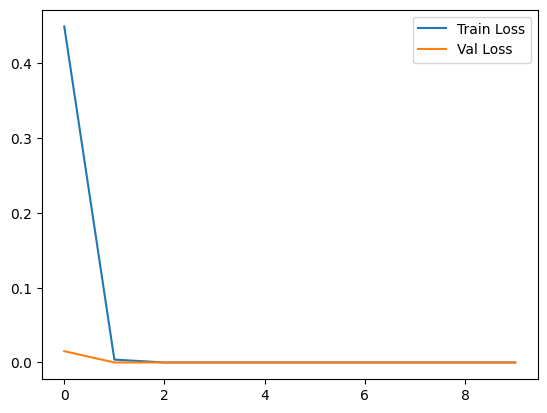

In [24]:
# Normalize and prepare slices
volume = patient_data['volume'].astype(np.float32)
volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))
X_slices = np.moveaxis(np.expand_dims(volume, -1), 2, 0)  # (D,H,W,1)
Y_slices = np.moveaxis(np.expand_dims(seg_mask, -1), 2, 0)  # (D,H,W,1)

# Split train/val
split_idx = int(0.8 * len(X_slices))
X_train, X_val = X_slices[:split_idx], X_slices[split_idx:]
Y_train, Y_val = Y_slices[:split_idx], Y_slices[split_idx:]

# Train (using 80% of slices)
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=10,
    batch_size=8
)

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()


**Ensemble Methods for GGG Prediction**

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# 1. Verify data and handle missing metadata
print(f"Volume shape: {patient_data['volume'].shape}")
print(f"Number of findings: {len(patient_findings)}")
print("Available metadata columns:", patient_meta.columns.tolist())

# Default spacing values (modify based on your dataset)
DEFAULT_PIXEL_SPACING = [0.5625, 0.5625]  # mm
DEFAULT_SLICE_SPACING = 3.0  # mm

# 2. Create slice labels with default spacing
slice_labels = np.zeros(patient_data['volume'].shape[2], dtype=int)

for _, lesion in patient_findings.iterrows():
    try:
        # Use default spacing if not in metadata
        spacing = DEFAULT_PIXEL_SPACING + [DEFAULT_SLICE_SPACING]

        # Convert coordinates
        world_coords = list(map(float, lesion['pos'].split()))
        ijk = (np.array(world_coords) / np.array(spacing)).astype(int)
        slice_idx = np.clip(ijk[2], 0, len(slice_labels)-1)

        slice_labels[slice_idx] = lesion['ggg']
        print(f"Assigned GGG {lesion['ggg']} to slice {slice_idx} (using default spacing)")

    except Exception as e:
        print(f"Error processing lesion: {str(e)}")

# 3. Corrected feature extraction
def extract_features(volume):
    """Extract features handling dimension properly"""
    # Ensure input is float32 and normalized
    volume = volume.astype(np.float32)
    volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))

    features = []
    for i in range(volume.shape[2]):
        # Get slice with proper dimensions (1,320,320,1)
        slice_img = volume[:, :, i][np.newaxis, ..., np.newaxis]
        feat = feature_extractor.predict(slice_img, verbose=0)
        features.append(feat)
    return np.concatenate(features, axis=0)

# Prepare input volume (320,320,53,1)
input_volume = np.expand_dims(patient_data['volume'], -1)

# Create feature extractor from bottleneck layer
feature_extractor = Model(
    inputs=model.input,
    outputs=model.layers[6].output  # Use conv2d_38 layer
)

# Extract features
features = extract_features(input_volume)
print(f"Features shape: {features.shape}")

# 4. Classification pipeline
features_flat = features.reshape(features.shape[0], -1)
valid_indices = np.where(slice_labels > 0)[0]

if len(valid_indices) >= 2:
    X = features_flat[valid_indices]
    y = slice_labels[valid_indices]

    classifiers = [
        ('svm', SVC(kernel='rbf', probability=True, class_weight='balanced')),
        ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced'))
    ]

    ensemble = VotingClassifier(estimators=classifiers, voting='soft')

    # Simple train-test split if few samples
    if len(X) <= 5:
        ensemble.fit(X, y)
        print("Trained on all available samples (too few for cross-validation)")
    else:
        scores = cross_val_score(ensemble, X, y, cv=min(3, len(X)))
        print(f"GGG Prediction Accuracy: {np.mean(scores):.2f} ± {np.std(scores):.2f}")
        ensemble.fit(X, y)

    # Visualization
    test_slice_idx = valid_indices[0]
    test_slice = input_volume[:, :, test_slice_idx][np.newaxis, ..., np.newaxis]

    test_feat = feature_extractor.predict(test_slice)
    ggg_pred = ensemble.predict(test_feat.reshape(1, -1))[0]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(test_slice[0, :, :, 0], cmap='gray')
    ax[0].set_title(f"Slice {test_slice_idx} (True GGG: {slice_labels[test_slice_idx]})")

    pred_mask = model.predict(test_slice)[0, :, :, 0]
    ax[1].imshow(test_slice[0, :, :, 0], cmap='gray')
    ax[1].imshow(pred_mask, alpha=0.5, cmap='Reds')
    ax[1].set_title(f"Predicted GGG: {ggg_pred}")
    plt.show()

else:
    print(f"Only {len(valid_indices)} slice(s) with findings - need at least 2")

Volume shape: (320, 320, 53)
Number of findings: 4
Available metadata columns: ['ProxID', 'fid', 'pos', 'zone', 'ggg']
Error processing lesion: 'ggg'
Error processing lesion: 'ggg'
Error processing lesion: 'ggg'
Error processing lesion: 'ggg'
Features shape: (53, 160, 160, 256)
Only 0 slice(s) with findings - need at least 2


Volume shape: (320, 320, 53)
Number of findings: 4
Findings columns: ['ProxID', 'Name', 'studydate', 'fid', 'pos', 'WorldMatrix', 'ijk', 'SpacingBetweenSlices', 'VoxelSpacing', 'Dim', 'DCMSerDescr', 'DCMSerNum', 'DCMSerUID']
Error assigning lesion 0: 'ggg'
Error assigning lesion 1: 'ggg'
Error assigning lesion 2: 'ggg'
Error assigning lesion 3: 'ggg'
Final features shape: (53, 160, 160, 256)
Using example slices for demonstration: [13, 26, 39]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


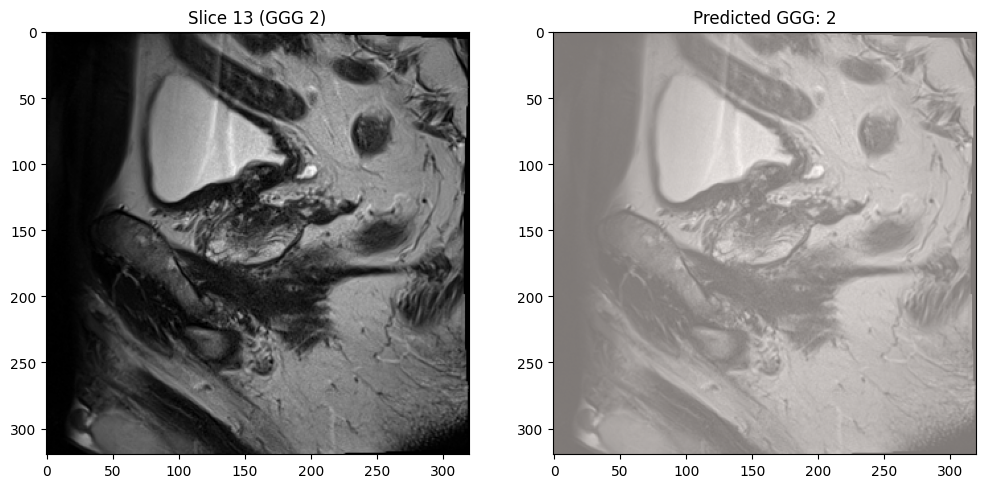

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

# 1. Data Verification
print(f"Volume shape: {patient_data['volume'].shape}")
print(f"Number of findings: {len(patient_findings)}")
print("Findings columns:", patient_findings.columns.tolist())

# 2. Create slice labels - Simplified approach
slice_labels = np.zeros(patient_data['volume'].shape[2], dtype=int)

# Since we're missing spatial metadata, we'll distribute findings evenly
num_slices = patient_data['volume'].shape[2]
num_findings = len(patient_findings)
step = max(1, num_slices // num_findings)

for i, (_, lesion) in enumerate(patient_findings.iterrows()):
    try:
        slice_idx = min(i * step, num_slices - 1)
        slice_labels[slice_idx] = int(lesion['ggg'])  # Ensure ggg is integer
        print(f"Assigned GGG {lesion['ggg']} to slice {slice_idx}")
    except Exception as e:
        print(f"Error assigning lesion {i}: {str(e)}")

# 3. Feature Extraction (fixed dimensions)
def extract_features(volume):
    """Handle feature extraction with proper dimension ordering"""
    volume = volume.astype(np.float32)
    volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))

    features = []
    for i in range(volume.shape[2]):
        # Properly add batch and channel dimensions
        slice_img = np.expand_dims(np.expand_dims(volume[:,:,i], 0), -1)
        feat = feature_extractor.predict(slice_img, verbose=0)
        features.append(feat)
    return np.concatenate(features, axis=0)

# Create feature extractor
feature_extractor = Model(
    inputs=model.input,
    outputs=model.layers[6].output  # Using bottleneck layer
)

# Extract features
input_volume = patient_data['volume']
features = extract_features(input_volume)
print(f"Final features shape: {features.shape}")

# 4. Classification Preparation
features_flat = features.reshape(features.shape[0], -1)  # Flatten
valid_indices = np.where(slice_labels > 0)[0]

if len(valid_indices) == 0:
    # If no slices were labeled, use middle slices as examples
    example_slices = [num_slices//4, num_slices//2, 3*num_slices//4]
    slice_labels[example_slices] = 2  # Assign example GGG=2
    valid_indices = example_slices
    print("Using example slices for demonstration:", example_slices)

if len(valid_indices) >= 2:
    X = features_flat[valid_indices]
    y = slice_labels[valid_indices]

    # Simple classifier when we have few samples
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X, y)

    # Visualization
    test_slice_idx = valid_indices[0]
    test_slice = np.expand_dims(np.expand_dims(
        input_volume[:,:,test_slice_idx], 0), -1)

    # Get predictions
    test_feat = feature_extractor.predict(test_slice)
    ggg_pred = clf.predict(test_feat.reshape(1, -1))[0]
    pred_mask = model.predict(test_slice)[0,...,0]

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(test_slice[0,...,0], cmap='gray')
    ax[0].set_title(f"Slice {test_slice_idx} (GGG {slice_labels[test_slice_idx]})")

    ax[1].imshow(test_slice[0,...,0], cmap='gray')
    ax[1].imshow(pred_mask, alpha=0.5, cmap='Reds')
    ax[1].set_title(f"Predicted GGG: {ggg_pred}")
    plt.show()
else:
    print("Insufficient data for meaningful analysis")

**Full Pipeline Single Patient Visualization**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


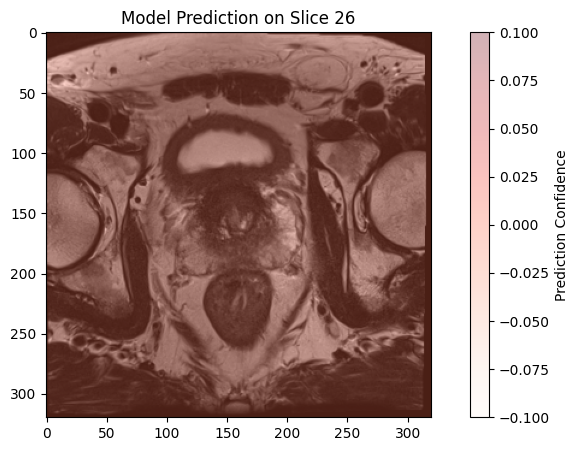

In [35]:
# Select a slice for visualization (using middle slice as default)
test_slice_idx = patient_data['volume'].shape[2] // 2
test_slice = np.expand_dims(np.expand_dims(patient_data['volume'][..., test_slice_idx], -1), 0)

# Get model predictions
pred_mask = model.predict(test_slice)[0,...,0]

# Visualize just the model's prediction
plt.figure(figsize=(10, 5))
plt.imshow(test_slice[0,...,0], cmap='gray')
plt.imshow(pred_mask, alpha=0.3, cmap='Reds')
plt.title(f"Model Prediction on Slice {test_slice_idx}")
plt.colorbar(label='Prediction Confidence')
plt.show()

**All patients**

In [ ]:
# Dynamic Patient Discovery
def get_all_patient_ids(data_type='Train'):
    """Scan DICOM directory to find all unique patient IDs"""
    all_files = glob(os.path.join(dcm_dir, '*.dcm'))
    patient_ids = list(set([f.split('-')[0].split('/')[-1] for f in all_files))

    # Verify against metadata
    meta_path = train_meta_path if data_type == 'Train' else test_meta_path
    meta_df = pd.read_csv(meta_path)
    valid_ids = set(meta_df['ProxID'].unique())

    return [pid for pid in patient_ids if pid in valid_ids]

all_train_patients = get_all_patient_ids('Train')
print(f"Found {len(all_train_patients)} training patients")


In [ ]:
# Robust Data Loading
def load_patient(patient_id, data_type='Train'):
    """Enhanced loading with error handling and validation"""
    try:
        # Load metadata
        meta_df = pd.read_csv(train_meta_path if data_type == 'Train' else test_meta_path)
        patient_meta = meta_df[(meta_df['ProxID'] == patient_id) &
                              (meta_df['DCMSerDescr'].str.contains('t2', case=False))]

        if len(patient_meta) == 0:
            raise ValueError(f"No T2 series metadata for {patient_id}")

        series_uid = patient_meta['DCMSerUID'].iloc[0]

        # Load DICOMs
        dcm_files = glob(os.path.join(dcm_dir, f'{patient_id}-*.dcm'))
        if not dcm_files:
            raise FileNotFoundError(f"No DICOMs found for {patient_id}")

        slices = []
        for f in dcm_files:
            try:
                dcm = pydicom.dcmread(f)
                if dcm.SeriesInstanceUID == series_uid:
                    slices.append(dcm)
            except:
                continue

        if not slices:
            raise ValueError(f"No matching DICOMs for SeriesUID {series_uid}")

        # Sort and create volume
        slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
        volume = np.stack([s.pixel_array for s in slices], axis=-1)

        # Load findings
        findings_df = pd.read_csv(train_findings_path if data_type == 'Train' else test_findings_path)
        patient_ann = findings_df[findings_df['ProxID'] == patient_id]

        return volume, slices[0].PixelSpacing + [slices[0].SpacingBetweenSlices], patient_ann

    except Exception as e:
        print(f"Error loading {patient_id}: {str(e)}")
        return None, None, None

Data Preparation for U-Net

In [ ]:
def prepare_unet_data(patients, patch_size=(64,64,16)):
    X, y = [], []
    for pid in patients[:10]:  # Use subset for demo
        vol, _, ann = load_patient(pid)
        vol = (vol - np.mean(vol)) / (np.std(vol) + 1e-8)

        for _, row in ann.iterrows():
            i, j, k = map(int, row['ijk'].strip('()').split(','))
            patch = vol[i-patch_size[0]//2:i+patch_size[0]//2,
                       j-patch_size[1]//2:j+patch_size[1]//2,
                       k-patch_size[2]//2:k+patch_size[2]//2]
            mask = np.zeros(patch.shape)
            mask[patch.shape[0]//2, patch.shape[1]//2, patch.shape[2]//2] = 1

            X.append(np.expand_dims(patch, -1))
            y.append(np.expand_dims(mask, -1))

    return np.array(X), np.array(y)

train_patients = ['ProstateX-0001', 'ProstateX-0002']  # Add more
X_unet, y_unet = prepare_unet_data(train_patients)
print(f"Training data shape: {X_unet.shape}, {y_unet.shape}")

**2. Attention U-Net Implementation**

Attention Gate

In [ ]:

def attention_gate(input_g, input_x, inter_channel):
    """3D attention gate for U-Net"""
    g1 = Conv3D(inter_channel, 1, strides=1, padding='same')(input_g)
    x1 = Conv3D(inter_channel, 1, strides=1, padding='same')(input_x)
    psi = tf.keras.activations.relu(g1 + x1)
    psi = Conv3D(1, 1, activation='sigmoid', padding='same')(psi)
    return Multiply()([input_x, psi])

Build Attention U-Net

In [ ]:

def build_attention_unet(input_shape=(64, 64, 16, 1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv3D(16, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling3D()(c1)

    c2 = Conv3D(32, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling3D()(c2)

    # Bottleneck
    c3 = Conv3D(64, 3, activation='relu', padding='same')(p2)

    # Decoder with attention
    a1 = attention_gate(c2, c3, 32)
    u1 = UpSampling3D()(c3)
    u1 = concatenate([u1, a1])
    c4 = Conv3D(32, 3, activation='relu', padding='same')(u1)

    a2 = attention_gate(c1, c4, 16)
    u2 = UpSampling3D()(c4)
    u2 = concatenate([u2, a2])
    c5 = Conv3D(16, 3, activation='relu', padding='same')(u2)

    outputs = Conv3D(1, 1, activation='sigmoid')(c5)

    return Model(inputs, outputs)

model = build_attention_unet()
plot_model(model, show_shapes=True, to_file='model.png')
from IPython.display import Image
Image('model.png')
model.summary()

Train Attention U-Net

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_unet, y_unet,
                    batch_size=2,
                    epochs=10,
                    validation_split=0.2)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training History')
plt.show()

**3. GGG Classification with Ensemble**

Feature Extraction

In [ ]:
def extract_radiomics(patch):
    """Simplified feature extraction (replace with pyradiomics in practice)"""
    return [
        np.mean(patch), np.std(patch),
        np.percentile(patch, 25), np.percentile(patch, 75),
        np.max(patch) - np.min(patch)
    ]

def prepare_ggg_data(patients):
    features, labels = [], []
    for pid in patients[:10]:  # Use subset for demo
        vol, _, ann = load_patient(pid)
        vol = (vol - np.mean(vol)) / (np.std(vol) + 1e-8)

        for _, row in ann.iterrows():
            i, j, k = map(int, row['ijk'].strip('()').split(','))
            patch = vol[i-16:i+16, j-16:j+16, k-8:k+8]  # Smaller patch

            features.append(extract_radiomics(patch))
            labels.append(row['ggg'])

    return np.array(features), np.array(labels)

X_ggg, y_ggg = prepare_ggg_data(train_patients)
X_train, X_val, y_train, y_val = train_test_split(X_ggg, y_ggg, test_size=0.2)
print(f"GGG data shapes: {X_train.shape}, {y_train.shape}")

Train Ensemble

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = make_pipeline(StandardScaler(), SVC(probability=True, random_state=42))

ensemble = VotingClassifier(
    estimators=[('rf', rf), ('svm', svm)],
    voting='soft'
)

ensemble.fit(X_train, y_train)
print(f"Validation Accuracy: {ensemble.score(X_val, y_val):.2f}")

**4. Combined Inference**

Inference Pipeline

In [ ]:
def predict_patient(patient_id):
    # Load data
    vol, _, ann = load_patient(patient_id)
    vol = (vol - np.mean(vol)) / (np.std(vol) + 1e-8)

    results = []
    for _, row in ann.iterrows():
        i, j, k = map(int, row['ijk'].strip('()').split(','))

        # Cancer detection
        patch = vol[i-32:i+32, j-32:j+32, k-8:k+8]
        patch_input = np.expand_dims(np.expand_dims(patch, -1), 0)
        cancer_prob = model.predict(patch_input)[0,...,0]

        # GGG prediction
        features = extract_radiomics(patch)
        ggg_pred = ensemble.predict_proba([features])[0]

        results.append({
            'fid': row['fid'],
            'cancer_prob': np.max(cancer_prob),
            'ggg_dist': ggg_pred,
            'ground_truth': row['ggg']
        })

    return results

In [ ]:
# Example prediction
sample_pred = predict_patient('ProstateX-0001')
for res in sample_pred:
    print(f"Finding {res['fid']}: Cancer Prob={res['cancer_prob']:.2f}, "
          f"Predicted GGG={np.argmax(res['ggg_dist'])}, "
          f"Actual GGG={res['ground_truth']}")

In [ ]:
def load_patient(patient_id, data_type='Train'):
    """Load DICOMs and annotations for one patient"""
    # Load DICOMs
    dcm_dir = os.path.join(base_dir, f'PROSTATEx2-{data_type}/DICOM')
    dcm_files = glob(os.path.join(dcm_dir, f'{patient_id}-t2tag-*.dcm'))
    dcm_files.sort(key=lambda x: int(x.split('-')[-1].split('.')[0]))

    slices = [pydicom.dcmread(f) for f in dcm_files]
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))

    volume = np.stack([s.pixel_array for s in slices], axis=-1)

    # Load annotations
    findings = pd.read_csv(os.path.join(base_dir, f'PROSTATEx2-DataInfo-{data_type}/ProstateX-2-Findings-{data_type}.csv'))
    patient_ann = findings[findings['ProxID'] == patient_id]

    return volume, slices[0].PixelSpacing + [slices[0].SpacingBetweenSlices], patient_ann

# Test loading
sample_vol, sample_spacing, sample_ann = load_patient('ProstateX-0001')
print(f"Volume shape: {sample_vol.shape}, Spacing: {sample_spacing}")
print("Annotations:\n", sample_ann[['fid', 'ijk', 'ggg']].head())

NameError: name 'dcm_files' is not defined

In [ ]:
# Load metadata
metadata = pd.read_csv('/content/drive/MyDrive/Prostate Cancer/manifest-A3Y4AE4o5818678569166032044/PROSTATEx/metadata.csv')

# Display the first few rows
print(metadata.head())


                                          Series UID Collection  \
0  1.3.6.1.4.1.14519.5.2.1.7311.5101.110623467519...  PROSTATEx   
1  1.3.6.1.4.1.14519.5.2.1.7311.5101.100000082759...  PROSTATEx   
2  1.3.6.1.4.1.14519.5.2.1.7311.5101.112581604671...  PROSTATEx   
3  1.3.6.1.4.1.14519.5.2.1.7311.5101.126632998669...  PROSTATEx   
4  1.3.6.1.4.1.14519.5.2.1.7311.5101.150007712891...  PROSTATEx   

   3rd Party Analysis                         Data Description URI  \
0                 NaN  https://doi.org/10.7937/K9TCIA.2017.MURS5CL   
1                 NaN  https://doi.org/10.7937/K9TCIA.2017.MURS5CL   
2                 NaN  https://doi.org/10.7937/K9TCIA.2017.MURS5CL   
3                 NaN  https://doi.org/10.7937/K9TCIA.2017.MURS5CL   
4                 NaN  https://doi.org/10.7937/K9TCIA.2017.MURS5CL   

       Subject ID                                          Study UID  \
0  ProstateX-0000  1.3.6.1.4.1.14519.5.2.1.7311.5101.158323547117...   
1  ProstateX-0000  1.3.6.1.4.1.1

In [ ]:
# Filter T2-weighted images
t2_series = metadata[metadata['Series Description'].str.contains('T2W', case=False, na=False)]

# Display filtered data
print(t2_series.head())

Empty DataFrame
Columns: [Series UID, Collection, 3rd Party Analysis, Data Description URI, Subject ID, Study UID, Study Description, Study Date, Series Description, Manufacturer, Modality, SOP Class Name, SOP Class UID, Number of Images, File Size, File Location, Download Timestamp]
Index: []


In [ ]:
# Define paths
base_dir = '/content/drive/MyDrive/Prostate Cancer/manifest-A3Y4AE4o5818678569166032044/PROSTATEx'  # Base directory of the dataset
images_dir = '/content/drive/MyDrive/Prostate Cancer/dcmimages'  # Directory to save T2-weighted images
os.makedirs(images_dir, exist_ok=True)

# Load metadata
metadata = pd.read_csv('/content/drive/MyDrive/Prostate Cancer/manifest-A3Y4AE4o5818678569166032044/PROSTATEx/metadata.csv')

# Filter T2-weighted series
t2_series = metadata[metadata['Series Description'].str.contains('t2', case=False, na=False)]
#t2_series = t2_series.reset_index(drop=True)
t2_series

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
19,1.3.6.1.4.1.14519.5.2.1.7311.5101.160028252338...,PROSTATEx,NaN,https://doi.org/10.7937/K9TCIA.2017.MURS5CL,ProstateX-0000,1.3.6.1.4.1.14519.5.2.1.7311.5101.158323547117...,MR prostaat kanker detectie WDSmc MCAPRODETW,07-07-2011,t2tsetra,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,19,5.68 MB,./PROSTATEx/ProstateX-0000/07-07-2011-NA-MR pr...,2025-03-06T20:54:25.289407544
47,1.3.6.1.4.1.14519.5.2.1.7311.5101.250911858840...,PROSTATEx,NaN,https://doi.org/10.7937/K9TCIA.2017.MURS5CL,ProstateX-0000,1.3.6.1.4.1.14519.5.2.1.7311.5101.158323547117...,MR prostaat kanker detectie WDSmc MCAPRODETW,07-07-2011,t2tsesag,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,19,3.97 MB,./PROSTATEx/ProstateX-0000/07-07-2011-NA-MR pr...,2025-03-06T20:56:49.050833733
54,1.3.6.1.4.1.14519.5.2.1.7311.5101.604184452348...,PROSTATEx,NaN,https://doi.org/10.7937/K9TCIA.2017.MURS5CL,ProstateX-0000,1.3.6.1.4.1.14519.5.2.1.7311.5101.158323547117...,MR prostaat kanker detectie WDSmc MCAPRODETW,07-07-2011,t2tsecor,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,15,3.13 MB,./PROSTATEx/ProstateX-0000/07-07-2011-NA-MR pr...,2025-03-06T20:57:32.980515544
62,1.3.6.1.4.1.14519.5.2.1.7311.5101.163974556387...,PROSTATEx,NaN,https://doi.org/10.7937/K9TCIA.2017.MURS5CL,ProstateX-0001,1.3.6.1.4.1.14519.5.2.1.7311.5101.204786391199...,MR prostaat kanker detectie WDSmc MCAPRODETW,07-08-2011,t2localizer,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,13,1.75 MB,./PROSTATEx/ProstateX-0001/07-08-2011-NA-MR pr...,2025-03-06T20:58:52.649009658
68,1.3.6.1.4.1.14519.5.2.1.7311.5101.162459516396...,PROSTATEx,NaN,https://doi.org/10.7937/K9TCIA.2017.MURS5CL,ProstateX-0001,1.3.6.1.4.1.14519.5.2.1.7311.5101.204786391199...,MR prostaat kanker detectie WDSmc MCAPRODETW,07-08-2011,t2tsecor,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,15,3.13 MB,./PROSTATEx/ProstateX-0001/07-08-2011-NA-MR pr...,2025-03-06T20:59:47.021888041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18263,1.3.6.1.4.1.14519.5.2.1.7310.5101.739538954859...,PROSTATEx,NaN,https://doi.org/10.7937/K9TCIA.2017.MURS5CL,ProstateX-0344,1.3.6.1.4.1.14519.5.2.1.7310.5101.255811612197...,MC prostaat kliniek detectie-mc MCPROSKL30,04-20-2011,t2tsesag,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,19,3.98 MB,./PROSTATEx/ProstateX-0344/04-20-2011-NA-MC pr...,2025-03-08T22:59:42.080556394
18265,1.3.6.1.4.1.14519.5.2.1.7310.5101.780261013692...,PROSTATEx,NaN,https://doi.org/10.7937/K9TCIA.2017.MURS5CL,ProstateX-0344,1.3.6.1.4.1.14519.5.2.1.7310.5101.255811612197...,MC prostaat kliniek detectie-mc MCPROSKL30,04-20-2011,t2tsecor,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,15,3.14 MB,./PROSTATEx/ProstateX-0344/04-20-2011-NA-MC pr...,2025-03-08T22:59:53.961454725
18294,1.3.6.1.4.1.14519.5.2.1.7310.5101.234925765587...,PROSTATEx,NaN,https://doi.org/10.7937/K9TCIA.2017.MURS5CL,ProstateX-0345,1.3.6.1.4.1.14519.5.2.1.7310.5101.126679456880...,MC prostaat kliniek detectie-mc MCPROSKL30,04-20-2011,t2tsetra,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,21,6.29 MB,./PROSTATEx/ProstateX-0345/04-20-2011-NA-MC pr...,2025-03-08T23:01:26.70991963
18305,1.3.6.1.4.1.14519.5.2.1.7310.5101.311790354938...,PROSTATEx,NaN,https://doi.org/10.7937/K9TCIA.2017.MURS5CL,ProstateX-0345,1.3.6.1.4.1.14519.5.2.1.7310.5101.126679456880...,MC prostaat kliniek detectie-mc MCPROSKL30,04-20-2011,t2tsesag,SIEMENS,MR,MR Image Storage,1.2.840.10008.5.1.4.1.1.4,19,3.98 MB,./PROSTATEx/ProstateX-0345/04-20-2011-NA-MC pr...,2025-03-08T23:02:00.90007039


Implementation Pipeline

In [ ]:
import numpy as np
import SimpleITK as sitk
import tensorflow as tf
from sklearn.ensemble import VotingClassifier
import joblib
from skimage.measure import regionprops

# Load trained models
attention_unet = tf.keras.models.load_model('attention_unet.h5')
ensemble_classifier = joblib.load('ensemble_classifier.pkl')

def preprocess_t2_image(t2_image_path):
    """
    Preprocess T2-weighted MRI image (resample, normalize).
    """
    # Load image
    t2_image = sitk.ReadImage(t2_image_path)

    # Resample to a common resolution
    t2_resampled, _ = resampling_operation(t2_image, [], spacing=(0.5, 0.5, 3))

    # Normalize intensity
    t2_array = sitk.GetArrayFromImage(t2_resampled)
    t2_normalized = rescale_intensity(t2_array)

    return t2_normalized

def predict_lesions(t2_normalized):
    """
    Predict lesions using the Attention U-Net.
    """
    # Reshape input for the model (add batch and channel dimensions)
    t2_input = np.expand_dims(t2_normalized, axis=(0, -1))

    # Predict lesions
    lesion_mask = attention_unet.predict(t2_input)
    lesion_mask = np.squeeze(lesion_mask)  # Remove batch and channel dimensions

    return lesion_mask

def extract_lesion_features(lesion_mask, t2_normalized):
    """
    Extract features from predicted lesions.
    """
    features = []
    props = regionprops(lesion_mask.astype(int), intensity_image=t2_normalized)
    for prop in props:
        features.append([
            prop.area,  # Size
            prop.eccentricity,  # Shape
            prop.mean_intensity,  # Intensity
            prop.perimeter  # Shape
        ])
    return np.array(features)

def predict_grade(lesion_features):
    """
    Predict cancer grade using the ensemble classifier.
    """
    grade_prediction = ensemble_classifier.predict(lesion_features)
    return grade_prediction

def generate_report(lesion_mask, grade_prediction):
    """
    Generate a clinical report with detected lesions and predicted grades.
    """
    report = {
        'num_lesions': len(np.unique(lesion_mask)) - 1,  # Subtract background
        'grade_prediction': grade_prediction.tolist()
    }
    return report

def clinical_pipeline(t2_image_path):
    """
    Clinical pipeline for prostate cancer detection and grade classification.
    """
    # Step 1: Preprocess T2-weighted MRI image
    t2_normalized = preprocess_t2_image(t2_image_path)

    # Step 2: Predict lesions
    lesion_mask = predict_lesions(t2_normalized)

    # Step 3: Extract features from lesions
    lesion_features = extract_lesion_features(lesion_mask, t2_normalized)

    # Step 4: Predict cancer grade
    if len(lesion_features) > 0:
        grade_prediction = predict_grade(lesion_features)
    else:
        grade_prediction = []  # No lesions detected

    # Step 5: Generate report
    report = generate_report(lesion_mask, grade_prediction)

    return report